# Table of Contents
 <p><div class="lev1 toc-item"><a href="#plot-NMI-as-beta-varies" data-toc-modified-id="plot-NMI-as-beta-varies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>plot NMI as beta varies</a></div><div class="lev1 toc-item"><a href="#Testing-on-football-network" data-toc-modified-id="Testing-on-football-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Testing on football network</a></div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import igraph as ig
import modbp
import forceatlas2 as fa2
import seaborn as sbn
# reload(modbp)

[[0.005 0.001]
 [0.001 0.005]]


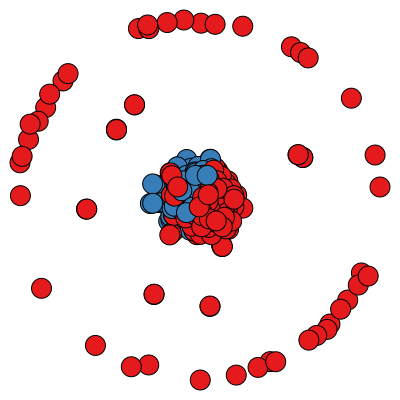

In [7]:
n=1000
q=2
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep)/(n*1.0/q)
pout=c/(1+1.0/ep)/(n*1.0/q)
t=time()
prob_mat=np.identity(nblocks)*pin + (np.ones((nblocks,nblocks))-np.identity(nblocks))*pout
print prob_mat
RSBM = modbp.RandomSBMGraph(n=n,comm_prob_mat=prob_mat)
color_dict=dict(zip(range(10),sbn.color_palette('Set1',10)))
# RSBM.graph.vs['color']=map(lambda x : color_dict[x],RSBM.graph.vs['block'])
m= RSBM.m
elist=RSBM.get_edgelist()
elist.sort()
pv=modbp.bp.PairVector(elist)

bpgc=modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=5, transform=False)
bpgc.run()
marg=np.array(bpgc.return_marginals())
# print marg
RSBM.graph.vs['color']=map(lambda x : color_dict[x] ,np.argmax(marg,axis=1))

#create forceatlas layout
adj=np.array(RSBM.get_adjacency().data)
pos=fa2.forceatlas2(adj,scalingRatio=10,gravity=1,strongGravityMode=False,edgeWeightInfluence=0)
layout=ig.Layout(pos)
ig.plot(RSBM.graph,layout=layout,inline=True,bbox=[400,400])

# plot NMI as beta varies

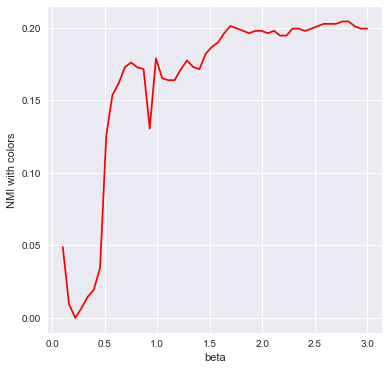

In [10]:
betas=np.linspace(.1,3,50)
fin_nmi=[]
for beta in betas:
    #This is where we would want to be able to recall the BP algorithm
    #without having to reconstruct the graph.  Presumably we could use 
    #the state of previous BP as warm initialization
    bpgc=modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=beta, transform=False)
    bpgc.run()
    marg=np.array(bpgc.return_marginals())
    color_dict={0:"red",1:"blue",2:'green'}
    RSBM.graph.vs['color']=map(lambda x : color_dict[np.argmax(x)],marg)
    cnmi=RSBM.get_AMI_with_blocks(RSBM.graph.vs['color'])
#     print("NMI at beta={:.2f}: {:.3f}".format(beta,cnmi))
    fin_nmi.append(cnmi)

fin_nmi=np.array(fin_nmi)
plt.close()
f,a=plt.subplots(1,1,figsize=(6,6))
a.plot(betas,fin_nmi,color='r')
a.set_xlabel('beta')
a.set_ylabel('NMI with colors')
plt.show()

[[0.01  0.002]
 [0.002 0.01 ]]
average degree: 2.832
modularity: 0.533


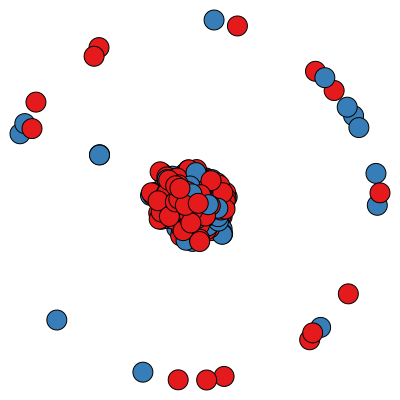

In [25]:
n=500
q=2
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep)/(n*1.0/q)
pout=c/(1+1.0/ep)/(n*1.0/q)
# pin=(5.5*q)/n
# pout=((5.5*.2)*q)/n
prob_mat = np.identity(q) * pin + (np.ones((q, q)) - np.identity(q)) * pout
print prob_mat
randSBM=modbp.RandomSBMGraph(n,prob_mat)
mbpinterface=modbp.ModularityBP(randSBM.graph)
print("average degree: {:.3f}".format(2.0*mbpinterface.m/mbpinterface.n))
beta=1
mbpinterface.run_modbp(beta=beta,q=q)
# mbpinterface.run_modbp(beta=1,q=2)

cols=sbn.color_palette('Set1',3)
mbpinterface.graph.vs['color']=map(lambda x : cols[x],mbpinterface.partitions[q][beta])

#create forceatlas layout
adj=np.array(mbpinterface.graph.get_adjacency().data)
pos=fa2.forceatlas2(adj,scalingRatio=50,gravity=1,strongGravityMode=False,edgeWeightInfluence=0)
layout=ig.Layout(pos)
print "modularity: {:.3f}".format(mbpinterface.retrival_modularities[q][beta])
ig.plot(mbpinterface.graph,layout=layout,inline=True,bbox=[400,400])


average degree: 3.020


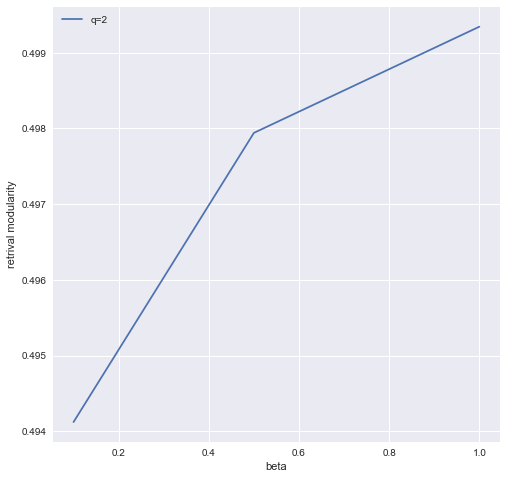

In [11]:
n=500
q=2
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep)/(n*1.0/q)
pout=c/(1+1.0/ep)/(n*1.0/q)
prob_mat = np.identity(q) * pin + (np.ones((q, q)) - np.identity(q)) * pout
randSBM=modbp.RandomSBMGraph(n,prob_mat)
mbpinterface=modbp.ModularityBP(randSBM.graph)
print("average degree: {:.3f}".format(2.0*mbpinterface.m/mbpinterface.n))
# betas=np.linspace(.01,3,30)
betas=np.array([.1,.5,1])
qs=np.array([2])#,4,5])

for q in qs:
    for beta in betas:
        mbpinterface.run_modbp(beta=beta,q=q)

plt.close()
f,a=plt.subplots(1,1,figsize=(8,8))

for q in qs:
    b,m=zip(*sorted(mbpinterface.retrival_modularities[q].items(),key=lambda x: x[0]))
    a.plot(b,m,label="q={:d}".format(q))
a.set_xlabel("beta")
a.set_ylabel("retrival modularity")
a.legend()
plt.show()


[(0.5, 1.0, 0.1), (0.970924819923346, 0.9822784593897762, 0.49859741295660676)]

# Testing on football network
We scan to look at how many communities are suggested

In [3]:
fbnet=ig.load("./football.net.graphml.gz")
n=fbnet.vcount()
elist=fbnet.get_edgelist()
elist.sort()
pv=modbp.bp.PairVector(elist)
bpgc=modbp.BP_Modularity(edgelist=pv, n=n, q=q, beta=1,resgamma=1, transform=False)
bpgc.run()
marg=np.array(bpgc.return_marginals())


print("time to construct {:.4f}".format(time()-t))

NameError: name 'q' is not defined